In [1]:
import tensorflow as tf
import segmentation_models as sm
from tensorflow import keras
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Segmentation Models: using `keras` framework.


In [2]:
sm.set_framework('tf.keras')
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [3]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

In [4]:
#Capture training image info as a list
train_images = []
for directory_path in glob.glob("data/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images) #.astype('float32').reshape((-1,1))

In [5]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("data/masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks) #.astype('float32').reshape((-1,1))

In [6]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
#Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [8]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)


In [13]:
# define model
model = sm.Unet(BACKBONE, classes=3, activation='sigmoid')
#model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_68[0][0]          
____________________________________________________________________________________________

In [14]:
history=model.fit(x_train, y_train, batch_size=8, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
37/37 [==============================] - 501s 13s/step - loss: 0.4512 - mse: 0.1593 - val_loss: 0.5818 - val_mse: 0.1547
Epoch 2/10
37/37 [==============================] - 494s 13s/step - loss: 0.1771 - mse: 0.0616 - val_loss: 126.2232 - val_mse: 0.6544
Epoch 3/10
37/37 [==============================] - 532s 14s/step - loss: 0.0800 - mse: 0.0436 - val_loss: 6.1967 - val_mse: 0.1399
Epoch 4/10
37/37 [==============================] - 603s 16s/step - loss: -0.0286 - mse: 0.0396 - val_loss: 0.0389 - val_mse: 0.0679
Epoch 5/10
37/37 [==============================] - 528s 14s/step - loss: -0.1777 - mse: 0.0402 - val_loss: 0.0578 - val_mse: 0.0787
Epoch 6/10
37/37 [==============================] - 545s 15s/step - loss: -0.3020 - mse: 0.0471 - val_loss: 1.4657 - val_mse: 0.4406
Epoch 7/10
37/37 [==============================] - 490s 13s/step - loss: -0.5462 - mse: 0.0420 - val_loss: -0.4018 - val_mse: 0.0819
Epoch 8/10
37/37 [==============================] - 487s 13s/step - l

3/3 [==============================] - 29s 8s/step - loss: -1.5472 - mse: 0.0401


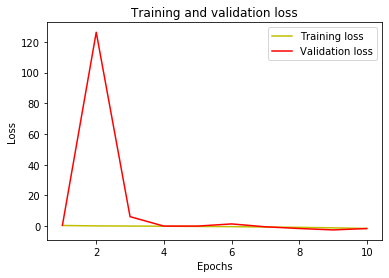

In [15]:
accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
model.save('membrane.h5')

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [26]:
from tensorflow import keras
model = keras.models.load_model('membrane.h5', compile=False)
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('data/images/011.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

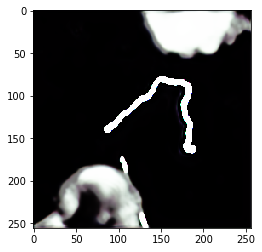

In [27]:
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('data/images/test0_segmented.jpg', prediction_image, cmap='gray')